<a href="https://colab.research.google.com/github/zeddie888/skribbl-bot/blob/main/pytorch_warmup.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook will help you get familiar with Google Colab, and walk you through modifying a simple model with PyTorch and training it on the [MNIST dataset](http://yann.lecun.com/exdb/mnist/)

To enable GPU:

Edit -> Notebook settings -> Hardware accelerator -> GPU -> Save

If you see an error about enabling third-party cookies check any ad-blockers you may be running and [enable third-party cookies on your browser](https://research.google.com/colaboratory/faq.html#third-party-cookies)





In [ ]:
# Download and install pytorch
# If you see "CUDA enabled: false" make sure you set the hardware accelerator for the notebook to GPU
from os import path

!pip install torch torchvision
  
import torch
print('Version', torch.__version__)
print('CUDA enabled:', torch.cuda.is_available())

The following section implements a simple model along with the train and test functions. Even with a single convolutional layer, two fully connected layers, and a tanh activation function you will see the accuracy is pretty high. Experiment with modifying different parts of the model to see how high you can get the accuracy to be. Specifically look into: 

*   Adding more [convolutional](https://pytorch.org/docs/stable/nn.html#convolution-layers) and [linear](https://pytorch.org/docs/stable/nn.html#linear-layers) layers
*   Adding a [pooling](https://pytorch.org/docs/stable/nn.html#convolution-layers) layer after the convolutional layer
*   Changing the [activation](https://pytorch.org/docs/stable/nn.html#non-linear-activations-weighted-sum-nonlinearity) layers in the forward pass
*   Adding [dropout](https://pytorch.org/docs/stable/nn.html#dropout-layers) layers


In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

# Create a PyTorch module to implement the model
class MNISTNet(nn.Module):
    def __init__(self):
        super(MNISTNet, self).__init__()
        
        # Model layers
        # Keep in mind the MNIST dataset provides grayscale images (1 channel) of 28 x 28 dimensions
        self.conv1 = nn.Conv2d(1, 3, 3)
        self.fc1 = nn.Linear(26 * 26 * 3, 512)
        self.fc2 = nn.Linear(512, 10)
        

    def forward(self, x):
        # Forward pass, this defines how the data actually passes through your network
        x = torch.tanh(self.conv1(x))
        x = x.view(-1, 26 * 26 * 3)
        x = torch.tanh(self.fc1(x))
        x = self.fc2(x)
        return x

    def loss(self, prediction, label, reduction='mean'):
        return F.cross_entropy(prediction, label, reduction = reduction)


def train(model, device, train_loader, optimizer, epoch, log_interval):
    model.train()
    for batch_idx, (data, label) in enumerate(train_loader):
        data, label = data.to(device), label.to(device)
        optimizer.zero_grad()
        
        output = model(data)
        loss = model.loss(output, label, 'mean')
        loss.backward()
        
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, label in test_loader:
            data, label = data.to(device), label.to(device)
            output = model(data)
            test_loss += model.loss(output, label).item()
            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(label.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

On top of modifying your model, also try changing these hyperparameters to set how quickly the model will learn and how much data it should train on.

In [ ]:
BATCH_SIZE = 256
TEST_BATCH_SIZE = 1000
EPOCHS = 5

LEARNING_RATE = 0.01
MOMENTUM = 0.5

USE_CUDA = True
SEED = 0 # Sets a seed for generating random numbers
LOG_INTERVAL = 100 # How often training results should be printed

In [ ]:
use_cuda = USE_CUDA and torch.cuda.is_available()

torch.manual_seed(SEED)

device = torch.device("cuda" if use_cuda else "cpu")
print('Using device', device)
import multiprocessing
print('num cpus:', multiprocessing.cpu_count())

kwargs = {'num_workers': multiprocessing.cpu_count(),
          'pin_memory': True} if use_cuda else {}
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=BATCH_SIZE, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=TEST_BATCH_SIZE, **kwargs)


model = MNISTNet().to(device)
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)

try:
    for epoch in range(0, EPOCHS + 1):
        train(model, device, train_loader, optimizer, epoch, LOG_INTERVAL)
        test(model, device, test_loader)
except KeyboardInterrupt as ke:
    print('Interrupted')
except:
    import traceback
    traceback.print_exc()
        

Run the following code block to grab a random image from the test dataset and see the prediction your trained model makes. Try running the code block multiple times to see what unique images your model might make mistakes on.

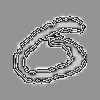

Prediction: 0


In [ ]:
import random

test_image = train_loader.dataset[random.randrange(2000)][0]
display(transforms.ToPILImage()(transforms.Resize(100)(test_image)))

with torch.no_grad():
  model.eval()
  out = model((test_image[None,...]).to(device))
  pred = out.max(1, keepdim=True)[1]
  print("Prediction: " + str(pred[0][0].item()))